# 获取数据

## 源数据
price: https://studio.glassnode.com/metrics?a=ETH&category=&ema=0&m=market.PriceUsdOhlc&mAvg=0&mMedian=0&s=1488326400&u=1709222399&zoom=

nvt ratio: https://studio.glassnode.com/metrics?a=ETH&category=&ema=0&m=indicators.Nvt&mAvg=0&mMedian=0&s=1488326400&u=1709222399&zoom=

## 训练集&测试集：

2017.3.1 - 2023.2.28

## 回测：

2023.3.1 - 2024.2.29

In [85]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

### 读取price数据

In [86]:
df = pd.read_csv('../data/eth_price.csv')
df.drop(df.columns[1], axis=1, inplace=True)
df.columns = ['date', 'close', 'high', 'low', 'open']
df['date'] = pd.to_datetime(df['date'])
df = df[(df['date'] >= '2017-03-01') & (df['date'] <= '2023-02-28')]
df

,date,close,high,low,open
0,2017-03-01,17.758000,17.758000,16.970000,16.970000
1,2017-03-02,19.208000,19.246000,19.144000,19.144000
2,2017-03-03,19.610000,20.040000,19.610000,20.040000
3,2017-03-04,18.702000,18.900000,18.660000,18.834000
4,2017-03-05,19.200000,19.200000,19.150000,19.152000
...,...,...,...,...,...
2186,2023-02-24,1608.825942,1609.737480,1603.595105,1603.595105
2187,2023-02-25,1594.292253,1594.548527,1590.587467,1590.756761
2188,2023-02-26,1639.417918,1640.586305,1631.641675,1631.641675
2189,2023-02-27,1633.450078,1635.025750,1631.954201,1632.693323


### 读取nvt ratio数据

In [87]:
df_nvt = pd.read_csv('../data/ethereum-network-value-to-transactions-ratio-nvt.csv')
df_nvt.columns = ['date', 'nvt ratio']
df_nvt['date'] = pd.to_datetime(df['date'])
df_nvt = df_nvt[(df_nvt['date'] >= '2017-03-01') & (df_nvt['date'] <= '2023-02-28')]
df_nvt

,date,nvt ratio
0,2017-03-01,7.576159
1,2017-03-02,5.164297
2,2017-03-03,5.427846
3,2017-03-04,8.371288
4,2017-03-05,9.768700
...,...,...
2186,2023-02-24,95.804672
2187,2023-02-25,155.020116
2188,2023-02-26,143.036149
2189,2023-02-27,79.292695


### 合并数据

In [88]:
df['NVT'] = df_nvt['nvt ratio']
df['NVT'] = df['NVT'].fillna(method='ffill')
df.to_csv('../data/input.csv')
df.set_index(['date'], inplace = True, drop=True) 
list_feature = list(df.columns)
print(list_feature)
df

['close', 'high', 'low', 'open', 'NVT']


,close,high,low,open,NVT
date,,,,,
2017-03-01,17.758000,17.758000,16.970000,16.970000,7.576159
2017-03-02,19.208000,19.246000,19.144000,19.144000,5.164297
2017-03-03,19.610000,20.040000,19.610000,20.040000,5.427846
2017-03-04,18.702000,18.900000,18.660000,18.834000,8.371288
2017-03-05,19.200000,19.200000,19.150000,19.152000,9.768700
...,...,...,...,...,...
2023-02-24,1608.825942,1609.737480,1603.595105,1603.595105,95.804672
2023-02-25,1594.292253,1594.548527,1590.587467,1590.756761,155.020116
2023-02-26,1639.417918,1640.586305,1631.641675,1631.641675,143.036149


# 多因子LSTM预测模型

### 特征归一化

拟合操作将计算数据的最小值和最大值，然后对数据进行缩放转换，使其落入指定的范围

缩放后的数据被存储在变量scaled中

In [89]:
values = df
values = values.astype('float32')

# 创建一个MinMaxScaler对象，用于将数据缩放到(0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))

# 使用MinMaxScaler对象对values进行拟合和转换操作
scaled = scaler.fit_transform(values)

scaled

array([[2.4529244e-04, 1.4494103e-04, 9.8947203e-05, 0.0000000e+00,
        1.8328594e-02],
       [5.4722326e-04, 4.5481557e-04, 5.5663171e-04, 4.5626750e-04,
        1.0371499e-02],
       [6.3093100e-04, 6.2016491e-04, 6.5473723e-04, 6.4431550e-04,
        1.1240985e-02],
       ...,
       [3.3792013e-01, 3.3809698e-01, 3.4003001e-01, 3.3887863e-01,
        4.6523154e-01],
       [3.3667746e-01, 3.3693898e-01, 3.4009582e-01, 3.3909935e-01,
        2.5493225e-01],
       [3.3109447e-01, 3.3215806e-01, 3.3476612e-01, 3.3477062e-01,
        3.4965530e-01]], dtype=float32)

### 将数据集转换为监督学习问题

In [90]:
from pandas import DataFrame
from pandas import concat

# 将时间序列数据转换成监督学习问题的格式
def series_to_supervised(data, list_feature, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    # 用于存储特征列和对应的名称
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(list_feature[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(list_feature[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(list_feature[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

n_in = 3  #用过去多少天的特征作为输入
n_out = 2  #预测未来多少天价格
# frame as supervised learning
reframed = series_to_supervised(scaled, list_feature, n_in, n_out)
reframed

,close(t-3),high(t-3),low(t-3),open(t-3),NVT(t-3),close(t-2),high(t-2),low(t-2),open(t-2),NVT(t-2),...,close(t),high(t),low(t),open(t),NVT(t),close(t+1),high(t+1),low(t+1),open(t+1),NVT(t+1)
3,0.000245,0.000145,0.000099,0.000000,0.018329,0.000547,0.000455,0.000557,0.000456,0.010371,...,0.000442,0.000383,0.000455,0.000391,0.020952,0.000546,0.000445,0.000558,0.000458,0.025562
4,0.000547,0.000455,0.000557,0.000456,0.010371,0.000631,0.000620,0.000655,0.000644,0.011241,...,0.000546,0.000445,0.000558,0.000458,0.025562,0.000706,0.000619,0.000728,0.000643,0.012613
5,0.000631,0.000620,0.000655,0.000644,0.011241,0.000442,0.000383,0.000455,0.000391,0.020952,...,0.000706,0.000619,0.000728,0.000643,0.012613,0.000494,0.000439,0.000516,0.000424,0.021820
6,0.000442,0.000383,0.000455,0.000391,0.020952,0.000546,0.000445,0.000558,0.000458,0.025562,...,0.000494,0.000439,0.000516,0.000424,0.021820,0.000000,0.000000,0.000000,0.000004,0.019592
7,0.000546,0.000445,0.000558,0.000458,0.025562,0.000706,0.000619,0.000728,0.000643,0.012613,...,0.000000,0.000000,0.000000,0.000004,0.019592,0.000296,0.000248,0.000316,0.000269,0.013209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,0.350926,0.350861,0.353734,0.352572,0.345120,0.341545,0.341479,0.344345,0.343353,0.316784,...,0.340337,0.340271,0.343253,0.342239,0.339932,0.331550,0.331673,0.334125,0.332992,0.309408
2186,0.341545,0.341479,0.344345,0.343353,0.316784,0.338716,0.338650,0.339919,0.338768,0.265249,...,0.331550,0.331673,0.334125,0.332992,0.309408,0.328524,0.328510,0.331387,0.330298,0.504768
2187,0.338716,0.338650,0.339919,0.338768,0.265249,0.340337,0.340271,0.343253,0.342239,0.339932,...,0.328524,0.328510,0.331387,0.330298,0.504768,0.337920,0.338097,0.340030,0.338879,0.465232
2188,0.340337,0.340271,0.343253,0.342239,0.339932,0.331550,0.331673,0.334125,0.332992,0.309408,...,0.337920,0.338097,0.340030,0.338879,0.465232,0.336677,0.336939,0.340096,0.339099,0.254932


### 拆分为输入矩阵和输出矩阵

根据给定的时间步长（n_in 和 n_out）以及特征名称（list_feature），构造输入特征（X）和目标变量（Y）的列名列表

并从 reframed 中选择对应的列作为输入和输出

t-3, t-2, ..., t-1 是过去10天的实际数据

t, t+1 是预测数据

In [91]:
print(reframed.columns)
list_use_feature = []
for j in range(len(list_feature)):
    for i in range(n_in):
        list_use_feature.append(list_feature[j]+'(t-%d)' % (i+1))
    
X = reframed[list_use_feature]
print('X columns: ',X.columns)

list_use_result = []
list_use_result.append('close(t)')
for i in range(n_out-1):
    list_use_result.append('close(t+%d)' % (i+1))
Y = reframed[list_use_result]
print('Y column: ', Y.columns)

Index(['close(t-3)', 'high(t-3)', 'low(t-3)', 'open(t-3)', 'NVT(t-3)',
       'close(t-2)', 'high(t-2)', 'low(t-2)', 'open(t-2)', 'NVT(t-2)',
       'close(t-1)', 'high(t-1)', 'low(t-1)', 'open(t-1)', 'NVT(t-1)',
       'close(t)', 'high(t)', 'low(t)', 'open(t)', 'NVT(t)', 'close(t+1)',
       'high(t+1)', 'low(t+1)', 'open(t+1)', 'NVT(t+1)'],
      dtype='object')
X columns:  Index(['close(t-1)', 'close(t-2)', 'close(t-3)', 'high(t-1)', 'high(t-2)',
       'high(t-3)', 'low(t-1)', 'low(t-2)', 'low(t-3)', 'open(t-1)',
       'open(t-2)', 'open(t-3)', 'NVT(t-1)', 'NVT(t-2)', 'NVT(t-3)'],
      dtype='object')
Y column:  Index(['close(t)', 'close(t+1)'], dtype='object')


### 拆分为训练集和测试集

将输入特征（X）和目标变量（Y）转换为适合在神经网络中使用的格式，并划分训练集和测试集

对输入特征进行形状调整，使其变成3D张量，其中包括批次大小、时间步长和特征数

In [92]:
print(X.shape, Y.shape)

X = X.values
Y = Y.values
n_train_days = int(X.shape[0]/3)
print('Number of samples in the training set: ', n_train_days)

# 前 n_train_days 个样本作为训练集，其余样本作为测试集
train_X, train_Y = X[:n_train_days, :], Y[:n_train_days, :]
test_X, test_Y = X[n_train_days:, :], Y[n_train_days:, :]

# reshape input to be 3D [batchs, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(2187, 15) (2187, 2)
Number of samples in the training set:  729
(729, 1, 15) (729, 2) (1458, 1, 15) (1458, 2)


### 构建及训练LSTM模型

1.  在模型中添加一个LSTM层，包含50个神经元，并指定输入数据的形状为(train_X.shape[1], train_X.shape[2])

    其中train_X.shape[1]表示时间步长，train_X.shape[2]表示特征数

2.  在模型中添加一个全连接（Dense）层，该层的输出维度与目标变量的维度相同，用于输出预测结果

3.  编译模型，指定损失函数为平均绝对误差（Mean Absolute Error，MAE），优化器为Adam

4.  使用训练数据训练模型，指定训练的迭代次数为50次，批次大小为72，同时使用测试数据进行验证

    verbose=2表示显示每个epoch的训练情况，shuffle=False表示不对数据进行洗牌

5.  绘制训练集和测试集的损失值随着训练迭代次数的变化曲线，分别使用train和test作为标签

Epoch 1/50


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 47ms/step - loss: 0.0521 - val_loss: 0.2035
Epoch 2/50
11/11 - 0s - 3ms/step - loss: 0.0353 - val_loss: 0.1531
Epoch 3/50
11/11 - 0s - 3ms/step - loss: 0.0276 - val_loss: 0.1183
Epoch 4/50
11/11 - 0s - 2ms/step - loss: 0.0230 - val_loss: 0.0934
Epoch 5/50
11/11 - 0s - 2ms/step - loss: 0.0183 - val_loss: 0.0683
Epoch 6/50
11/11 - 0s - 2ms/step - loss: 0.0141 - val_loss: 0.0412
Epoch 7/50
11/11 - 0s - 2ms/step - loss: 0.0097 - val_loss: 0.0356
Epoch 8/50
11/11 - 0s - 3ms/step - loss: 0.0076 - val_loss: 0.0297
Epoch 9/50
11/11 - 0s - 3ms/step - loss: 0.0060 - val_loss: 0.0282
Epoch 10/50
11/11 - 0s - 2ms/step - loss: 0.0064 - val_loss: 0.0267
Epoch 11/50
11/11 - 0s - 2ms/step - loss: 0.0058 - val_loss: 0.0335
Epoch 12/50
11/11 - 0s - 2ms/step - loss: 0.0061 - val_loss: 0.0265
Epoch 13/50
11/11 - 0s - 2ms/step - loss: 0.0056 - val_loss: 0.0210
Epoch 14/50
11/11 - 0s - 2ms/step - loss: 0.0063 - val_loss: 0.0317
Epoch 15/50
11/11 - 0s - 2ms/step - loss: 0.0061 - val_loss: 0.0246

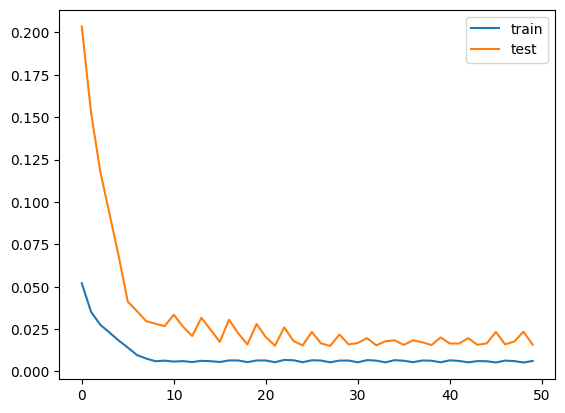

In [93]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot

# design network
model = Sequential()   # 创建一个序贯模型，即一个线性层叠模型
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(train_Y.shape[1]))  # 全连接层
model.compile(loss='mae', optimizer='adam') 
# fit network
history = model.fit(train_X, train_Y, epochs=50, batch_size=72, validation_data=(test_X, test_Y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### 评估模型

predictiony0 和 predictiony1分别表示close(t)和close(t+1)的预测结果

In [94]:
# 使用训练好的模型对测试集数据进行预测
Yhat = model.predict(test_X)
Yhat

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([[0.02741915, 0.02662976],
       [0.02713503, 0.02599726],
       [0.02589379, 0.02486153],
       ...,
       [0.34986964, 0.339691  ],
       [0.34327036, 0.3346474 ],
       [0.3478207 , 0.33543783]], dtype=float32)

In [95]:
from numpy import concatenate
import copy

# make a prediction
inv_Yhat = copy.deepcopy(Yhat)
print('close(t)', inv_Yhat[:,0].reshape(-1)[:10])
print('close(t+1)', inv_Yhat[:,1].reshape(-1)[:10])
print(Yhat.shape)
print(scaled[n_train_days:, :].shape)

inv_Yhat0 = concatenate((scaled[n_in:-n_out+1, :3][n_train_days:,:],
                         Yhat[:,:1], 
                         scaled[n_in:-n_out+1, 4:][n_train_days:,:]), axis=1)
inv_Yhat0 = scaler.inverse_transform(inv_Yhat0)
inv_Yhat0 = inv_Yhat0[:,3]

inv_Yhat1 = concatenate((scaled[n_in:-n_out+1, :3][n_train_days:,:],
                         Yhat[:,1:], 
                         scaled[n_in:-n_out+1, 4:][n_train_days:,:]), axis=1)
inv_Yhat1 = scaler.inverse_transform(inv_Yhat1)
inv_Yhat1 = inv_Yhat1[:,3]

predictiony0 = inv_Yhat0.reshape(-1)
predictiony1 = inv_Yhat1.reshape(-1)
originaly = values['close'].values[n_in:-n_out+1][n_train_days:]
x = values.index[n_in:-n_out+1][n_train_days:]
print(len(predictiony0), predictiony0[:10])
print(len(predictiony1), predictiony1[:10])
print(len(originaly), originaly[:10])
print(len(x), x[:10]) 
print(values.index)

close(t) [0.02741915 0.02713503 0.02589379 0.02616537 0.02747927 0.02812638
 0.02790577 0.02743869 0.02786556 0.02760249]
close(t+1) [0.02662976 0.02599726 0.02486153 0.0254574  0.02668911 0.02721134
 0.02689092 0.02672653 0.02692041 0.026435  ]
(1458, 2)
(1462, 5)
1458 [147.61539 146.26158 140.34738 141.64143 147.90184 150.98514 149.93398
 147.70847 149.74239 148.48894]
1458 [143.85411 140.84042 135.42894 138.26811 144.13689 146.6252  145.09848
 144.31519 145.23898 142.92616]
1458 [132.31317  127.364334 137.62025  138.85744  138.03114  135.04436
 137.80812  137.016    133.86957  134.4906  ]
1458 DatetimeIndex(['2019-03-03', '2019-03-04', '2019-03-05', '2019-03-06',
               '2019-03-07', '2019-03-08', '2019-03-09', '2019-03-10',
               '2019-03-11', '2019-03-12'],
              dtype='datetime64[ns]', name='date', freq=None)
DatetimeIndex(['2017-03-01', '2017-03-02', '2017-03-03', '2017-03-04',
               '2017-03-05', '2017-03-06', '2017-03-07', '2017-03-08',
      

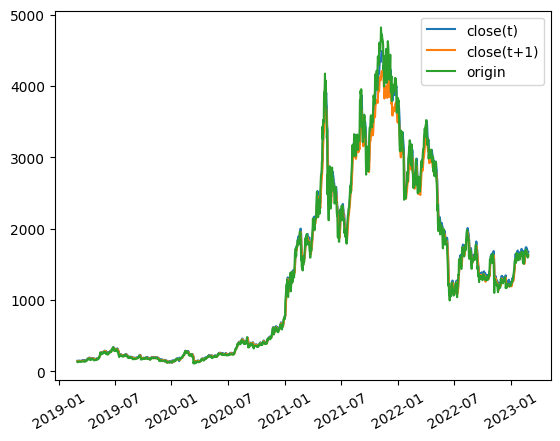

In [96]:
import matplotlib.pyplot as plt

plt.figure()
plt.xticks(rotation=30)
plt.plot(x, predictiony0, label='close(t)')
plt.plot(x, predictiony1, label='close(t+1)')
plt.plot(x, originaly, label='origin')
plt.legend()
plt.show()

In [114]:
import numpy as np
prediction = pd.DataFrame(np.concatenate((np.expand_dims(predictiony0, axis=1), np.expand_dims(predictiony1, axis=1)), axis=1), columns=['close(t)', 'close(t+1)'])
prediction.insert(0, 'date', x)

prediction

,date,close(t),close(t+1)
0,2019-03-03,147.615387,143.854111
1,2019-03-04,146.261581,140.840424
2,2019-03-05,140.347382,135.428940
3,2019-03-06,141.641434,138.268112
4,2019-03-07,147.901840,144.136887
...,...,...,...
1453,2023-02-23,1708.970581,1659.118896
1454,2023-02-24,1692.767822,1649.876831
1455,2023-02-25,1684.010986,1635.512451
1456,2023-02-26,1652.567139,1611.480835


In [115]:
prediction.to_csv('../data/prediction_result.csv')